# Getting Started

This notebook is intended to be a brief introduction into some of the most important classes and methods in `kl-tools`. We need to write more thorough documentation later!

Many sections are still labeled with Work In Progress (WIP), and will be updated over time.

If you have not installed the software yet, please see the repo's `README`

In [1]:
import numpy as np
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from copy import copy
import matplotlib.pyplot as plt

# some general kl-tools helper methods
from kl_tools.utils import add_colorbar

## Velocity Maps [WIP]

In [2]:
import kl_tools.velocity as velocity

# first, the default velocity model (perfectly centered)
centered_model_pars = {
    'g1': 0.1,
    'g2': -0.05,
    'theta_int': np.pi/6, # radians; will be an OrientedAngle soon
    'sini': 0.8,
    'v0': 0.0, # units set below
    'vcirc': 200, # units set below
    'rscale': 5, # units set below
    'r_unit': u.Unit('pixel'),
    'v_unit': u.km / u.s,
}

centered_model = velocity.VelocityModel(centered_model_pars)

# now an off-centered velocity model
offset_model_pars = copy(centered_model_pars)
offset_model_pars['x0'] = 10
offset_model_pars['y0'] = -5

offset_model = velocity.OffsetVelocityModel(offset_model_pars)

# you can also make a velocity model object dynamically from a builder method:
built_model = velocity.build_model('offset', offset_model_pars)


Now let's connect the models to a coordinate grid:

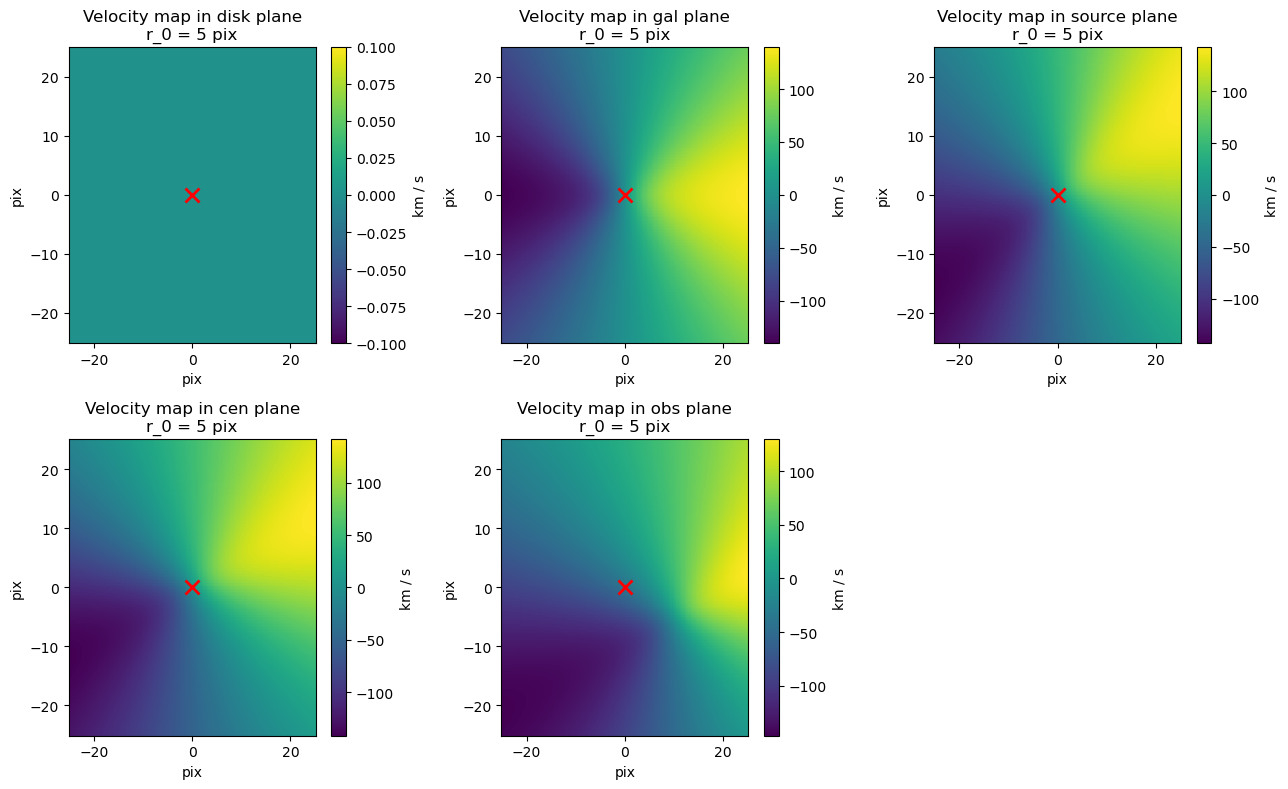

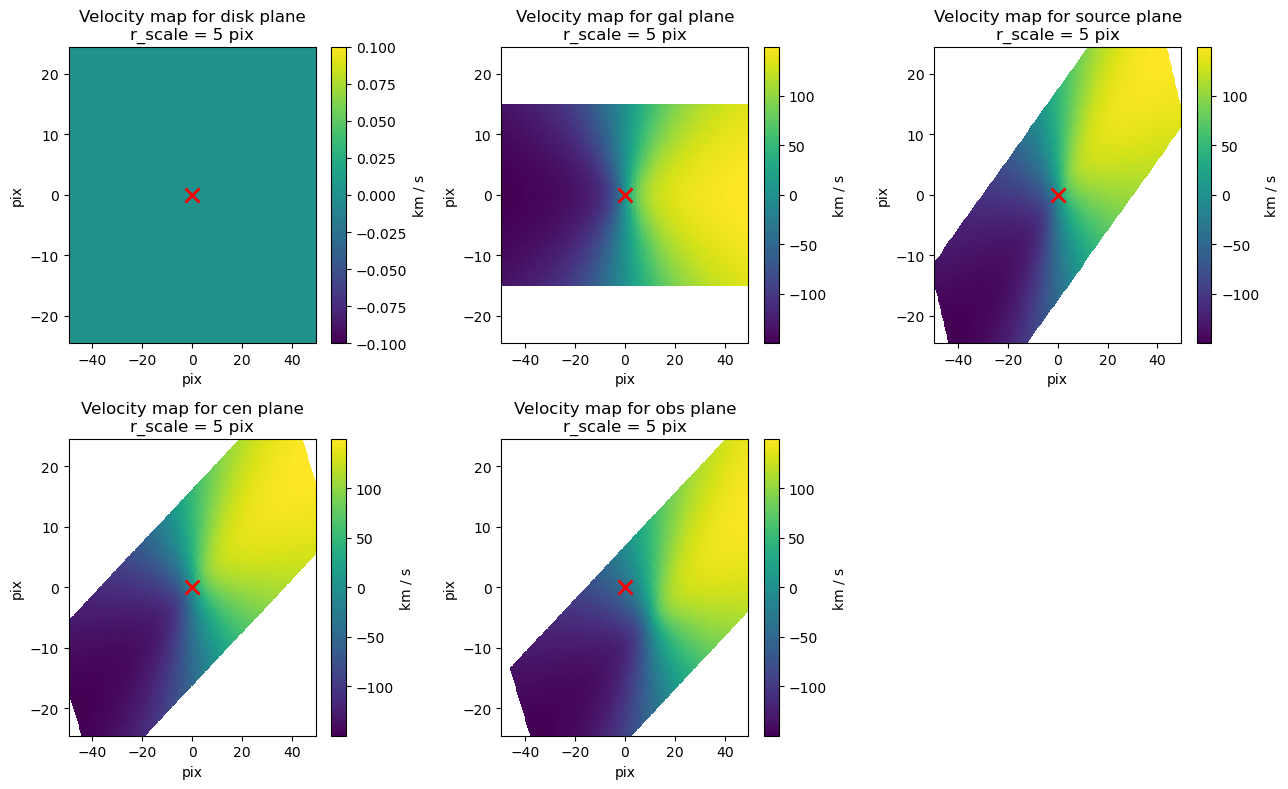

In [3]:
from kl_tools.utils import build_map_grid

# there are two ways to build image grids, depending on whether you want to think about dimensions as X-Y images or row-column numpy arrays
Nx, Ny = 100, 50 # dimensions of the X-Y grid
Nrow, Ncol = Ny, Nx # dimensions of the row-column grid
X, Y = build_map_grid(Nx, Ny, indexing='ij')

vmap = velocity.VelocityMap('offset', offset_model_pars)
obs_image = vmap('obs', X, Y)

vmap.plot_all_planes()
vmap.plot_map_transforms(X=X, Y=Y)


## Intensity Maps [WIP]

A lot to still say here - stay tuned!

### Basis Functions for Intensity Maps

For more complex flux distributions, it can be useful to leverage various types of basis function fits to capture general anisotropic features - particularly if combined with a smooth, Sersic model for the bulk of the emission. Here we will describe how to interact with the currently adapted basis function sets:
1. [Shapelets](https://arxiv.org/pdf/astro-ph/0105178): 2D, real, Cartesian functions analogous to the eigenstates of the quantum harmonic oscillator.
- The first in a series of attempts to use an appropriate basis to describe complex galaxy morphologies for lensing measurements, but has limitations due to (1) a Gaussian ground state that is a poor match to both disk and bulge galaxies, and (2) the Cartesian sampling of distributions that have steep slopes relative to the pixel grid.
2. [Exponential Shapeletes](https://arxiv.org/pdf/1903.05837): 2D, complex, polar functions analogous to the eigenstates of the 2D Hydrogen atom.
- Solves the 2 primary issues noted above for Shapelets, as they are polar functions with an exponential ground state that is a good match for disk galaxies.
3. [Sersiclets](https://arxiv.org/pdf/1106.6045): 2D, complex, polar functions similar to Exponential Shapalets but with a ground state specified as an arbitrary Sersic profile.
- An extension of Exponential Shapelets to arbitrary ground-state to match any desired Sersic profile.

We show a few (still incomplete) examples of how to interact with these bases below:

Number of Shapelets for nmax=3: 10


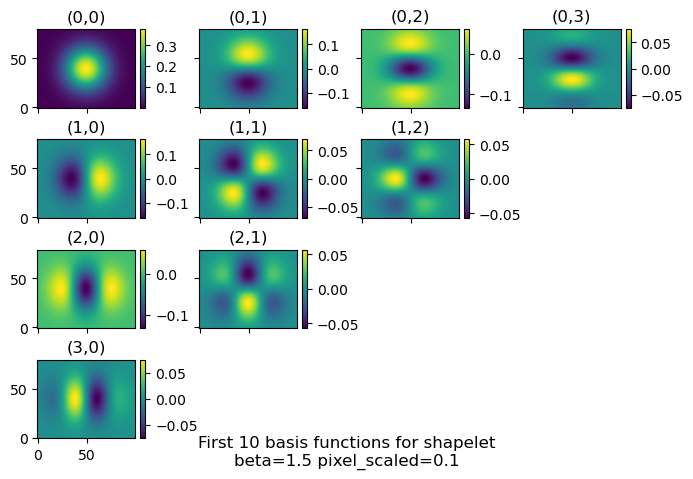

Number of Shapelets for nmax=3: 10


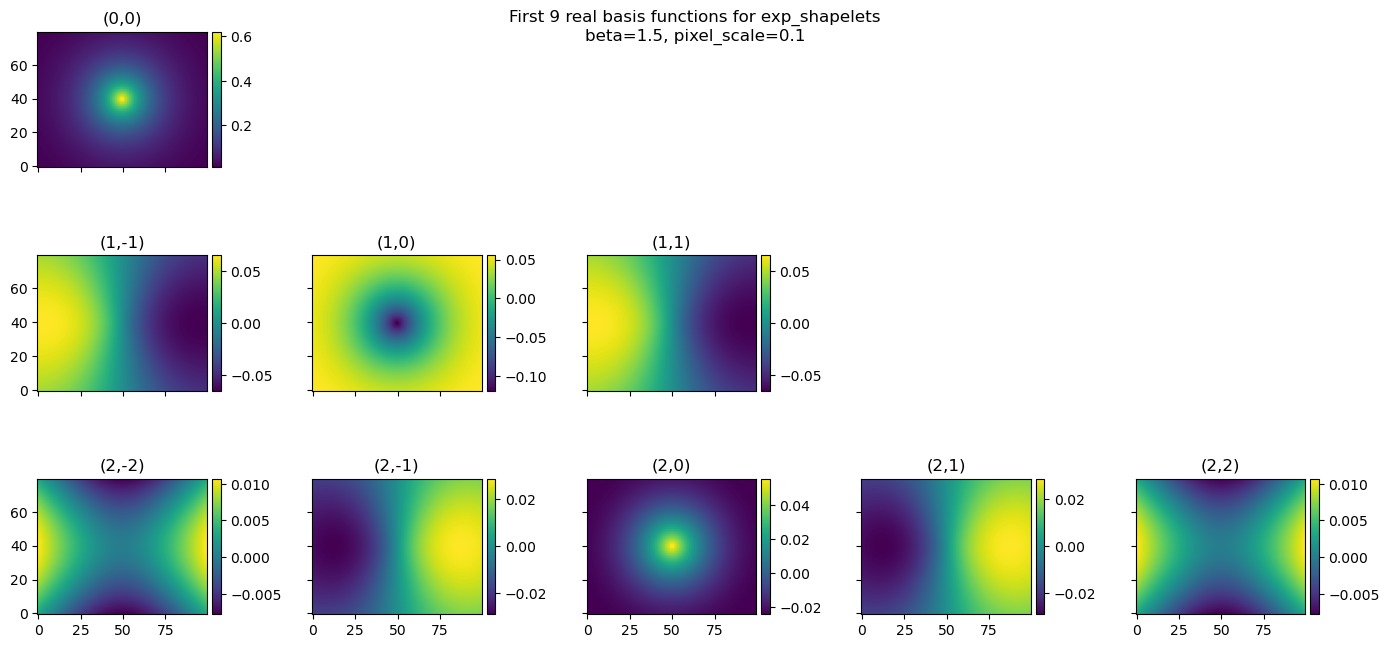

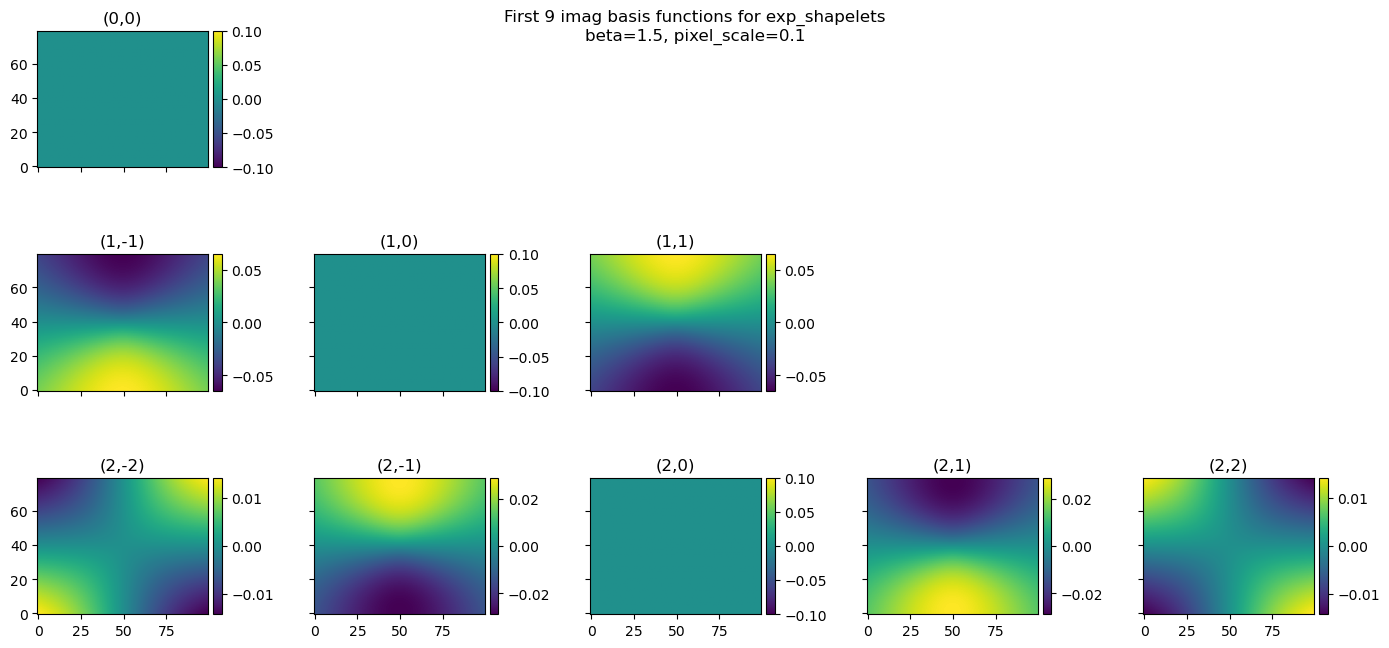

Number of Sersiclets for nmax=3: 10


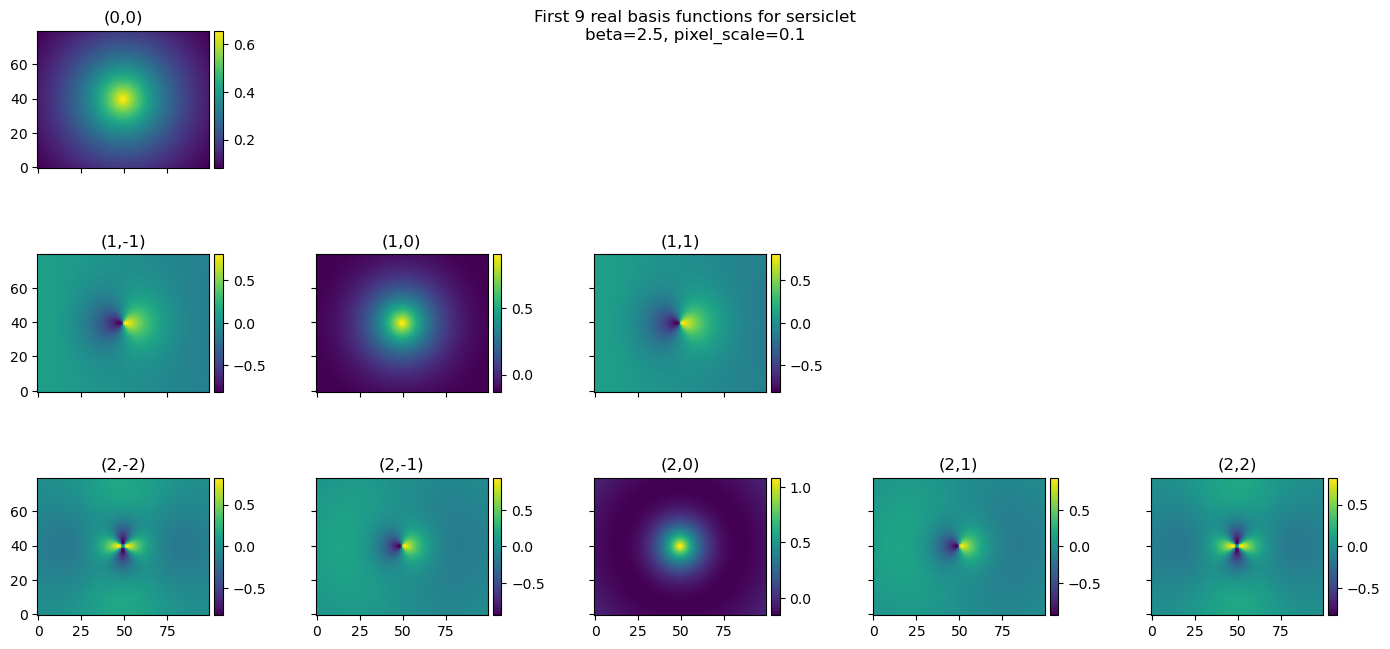

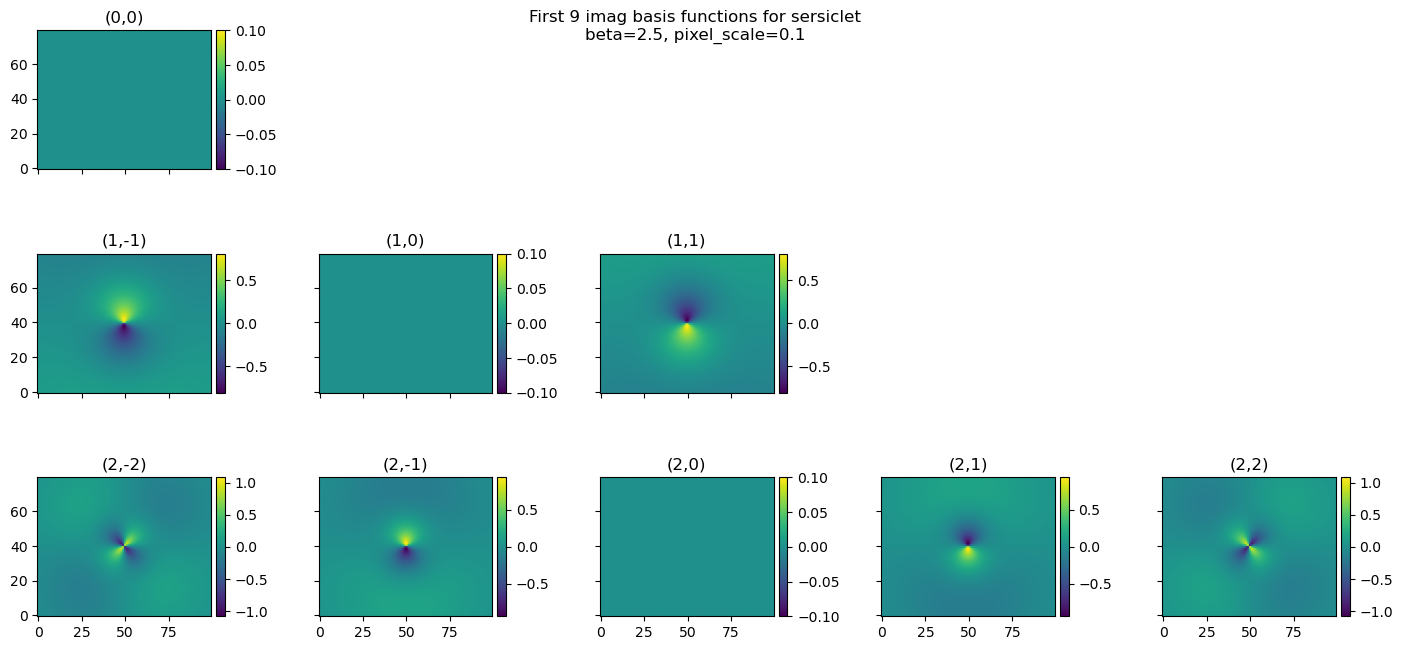

In [4]:
import kl_tools.basis as basis

# NOTE: All interactions with basis code are done in *coordinate* (x,y) space,
# *not* in numpy (row,col) space. When rendering a basis onto an image, you
# specify the image parameters such as Nx, Ny, and the pixel scale and it
# does the rest for you

# image info
Nx, Ny = 100, 80
pixel_scale = 0.1 # arcsec/pixel

nmax = 3 # has a different meaning for cartesian & polar bases, defined below

#-------------------------------------------------------------------------------
# shapelets first

shapelet_pars = {
    'nmax': nmax, # the max of nx+ny for a harmonic oscillator
    'beta': 1.5, # scale radius in units of the pixel scale; typically arcsec
    'psf': None, # can pass a galsim PSF instance here, will demo later!
}

# can also do shapelets = basis.Shapelets(...)
shapelets = basis.build_basis('shapelets', shapelet_pars)

# QHO has (nmax+1)*(nmax+2)/2 elements; triangular number!
print(f'Number of Shapelets for nmax={nmax}: {shapelets.N}')

shapelets.plot_basis_funcs(
    Nx, Ny, pixel_scale, size=(7,5)
    )

#-------------------------------------------------------------------------------
# now exponential shapelets

exp_shapelet_pars = {
    'nmax': nmax, # the largest principle quantum number n
    'beta': 1.5, # scale radius in units of the pixel scale; typically arcsec
}

# can also do shapelets = basis.ExpShapeletBasis(...)
exp_shapelets = basis.build_basis('exp_shapelets', exp_shapelet_pars)

# Hydrogen atom has n^2 elements
print(f'Number of Shapelets for nmax={nmax}: {shapelets.N}')

exp_shapelets.plot_basis_funcs(
    Nx, Ny, pixel_scale
    )

#-------------------------------------------------------------------------------
# finally, sersiclets

sersiclets_pars = {
    'index': 1.0, # the Sersic index
    'nmax': nmax, # the largest principle quantum number n
    'beta': 2.5, # scale radius in units of the pixel scale; typically arcsec
}

# can also do sersiclets = basis.SersicletBasis(...)
sersiclets = basis.build_basis('sersiclets', sersiclets_pars)

# Hydrogen atom has n^2 elements
print(f'Number of Sersiclets for nmax={nmax}: {shapelets.N}')

sersiclets.plot_basis_funcs(
    Nx, Ny, pixel_scale
    )

## Datacubes [WIP]

More to come!

In [5]:
from kl_tools.cube import DataCube, CubePars

### KROSS Datacubes [WIP]

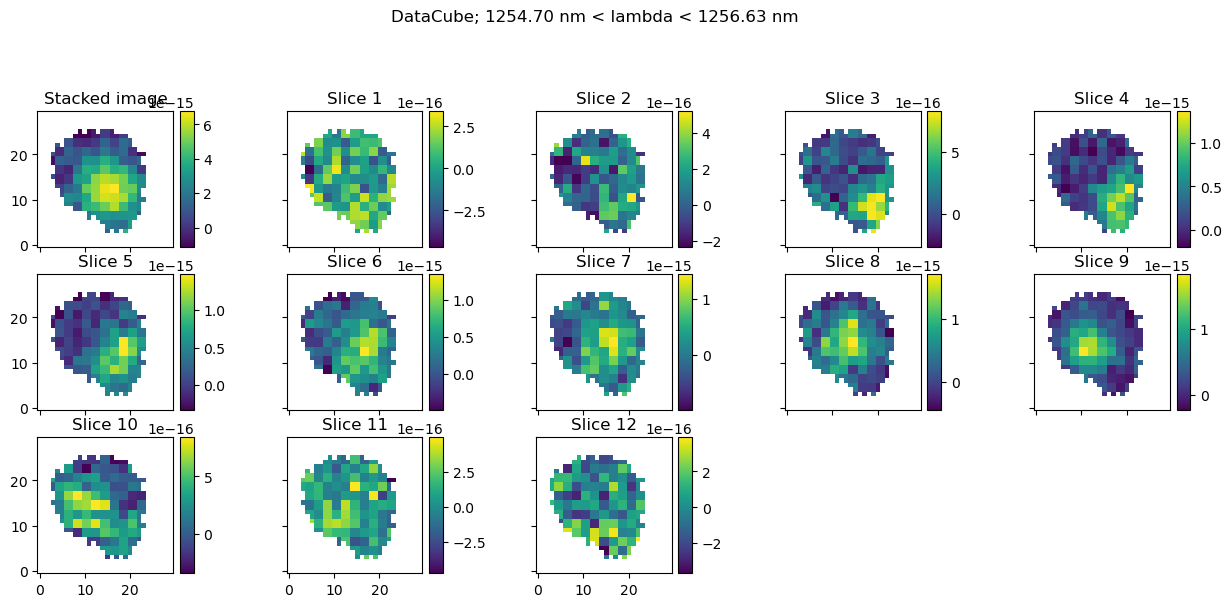

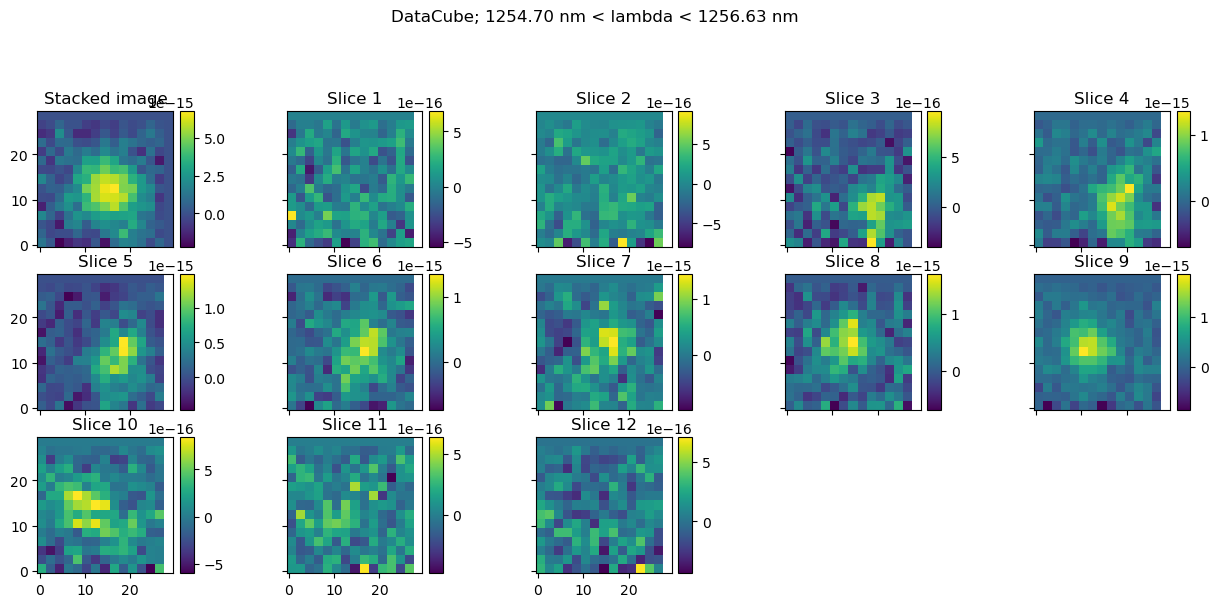

10h00m56.2704s +02d18m41.01912s


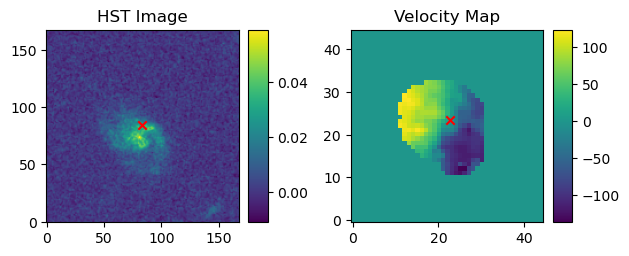

In [6]:
from kl_tools.kross.cube import KROSSDataCube
from kl_tools.kross.data import get_kross_obj_data

kid = 171
cube = KROSSDataCube(kid)

# truncate to the Halpha line
cube.set_line('Ha')

# might be helpful later on
obj_data = get_kross_obj_data(kid)

image = obj_data['hst']
image_wcs = WCS(obj_data['hst_hdr'])
vmap = obj_data['velocity']
vmap_wcs = WCS(obj_data['velocity_hdr'])

# mask on
cube.plot(show=True, mask=True, max_cols=5)
# mask off
cube.plot(show=True, mask=False, max_cols=5)

# get the center of the obj
row = obj_data['catalog']
ra = row['RA'][0]
dec = row['DEC'][0]
coord = SkyCoord(ra, dec, unit='deg')
print(coord.to_string('hmsdms'))

image_center = image_wcs.world_to_pixel(coord)
vmap_center = vmap_wcs.world_to_pixel(coord)

plt.subplot(121)
im = plt.imshow(image, origin='lower')
add_colorbar(im)
plt.scatter(*image_center, marker='x', color='r')
plt.title('HST Image')

plt.subplot(122)
im = plt.imshow(vmap, origin='lower')
add_colorbar(im)
plt.scatter(*vmap_center, marker='x', color='r')
plt.title('Velocity Map')

# plt.suptitle(f'KID {kid} Data Vector')
plt.tight_layout()
